# Day 5 - Your Analysis
## Analysis of patch-clamp data from ./patch_data_2024 folder

This notebook loads and analyzes ABF files from the patch_data_2024 folder.


In [1]:
import os
import glob
import numpy as np
import pandas as pd

# Import ABF files library
import pyabf

# Find Peaks and signal processing
import scipy
from scipy import signal
from scipy.signal import find_peaks

# Plots
import matplotlib.pyplot as plt

plt.close('all')


## 1. Load ABF Files from patch_data_2024 folder


In [2]:
# Define the data folder
data_folder = './patch_data_2024'

# Find all ABF files in the folder
abf_files = glob.glob(os.path.join(data_folder, '*.abf'))

print(f"Found {len(abf_files)} ABF file(s):")
for file in abf_files:
    print(f"  - {os.path.basename(file)}")


Found 2 ABF file(s):
  - Spike recording.abf
  - CheRiff current.abf


## 2. Load and explore a single ABF file


In [3]:
# Select the first ABF file (or change index to select another)
if len(abf_files) > 0:
    selected_file = abf_files[0]
    print(f"Loading: {os.path.basename(selected_file)}")
    
    # Load the ABF file
    abf = pyabf.ABF(selected_file)
    
    # Print basic information
    print(f"\nFile Information:")
    print(f"  Sampling rate: {abf.dataRate} Hz")
    print(f"  Number of sweeps: {abf.sweepCount}")
    print(f"  Number of channels: {abf.channelCount}")
    print(f"  Duration: {abf.sweepLengthSec} seconds per sweep")
    print(f"  Y-axis label: {abf.sweepLabelY}")
    print(f"  X-axis label: {abf.sweepLabelX}")
else:
    print("No ABF files found in the folder!")


Loading: Spike recording.abf

File Information:
  Sampling rate: 10000 Hz
  Number of sweeps: 50
  Number of channels: 3
  Duration: 1.0 seconds per sweep
  Y-axis label: Clamp Current (pA)
  X-axis label: Time (seconds)


## 3. Plot all sweeps from the selected file


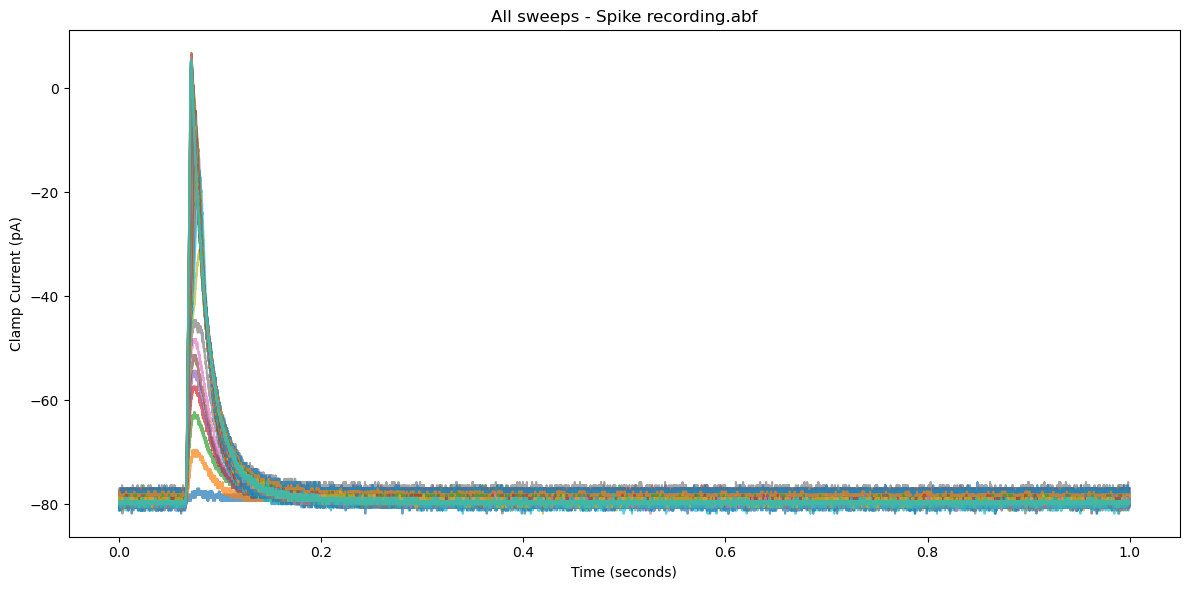

In [4]:
# Plot all sweeps in the ABF file
if len(abf_files) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for sweepNumber in abf.sweepList:
        abf.setSweep(sweepNumber)
        time = abf.sweepX
        y_variable = abf.sweepY
        
        # Plot each sweep
        ax.plot(time, y_variable, alpha=0.7, label=f'Sweep {sweepNumber}')
    
    ax.set_ylabel(abf.sweepLabelY)
    ax.set_xlabel(abf.sweepLabelX)
    ax.set_title(f'All sweeps - {os.path.basename(selected_file)}')
    
    # Add legend if there are multiple sweeps
    if abf.sweepCount > 1 and abf.sweepCount <= 10:
        ax.legend()
    
    plt.tight_layout()
    plt.show()


## 4. Plot individual sweep with filtering (optional)


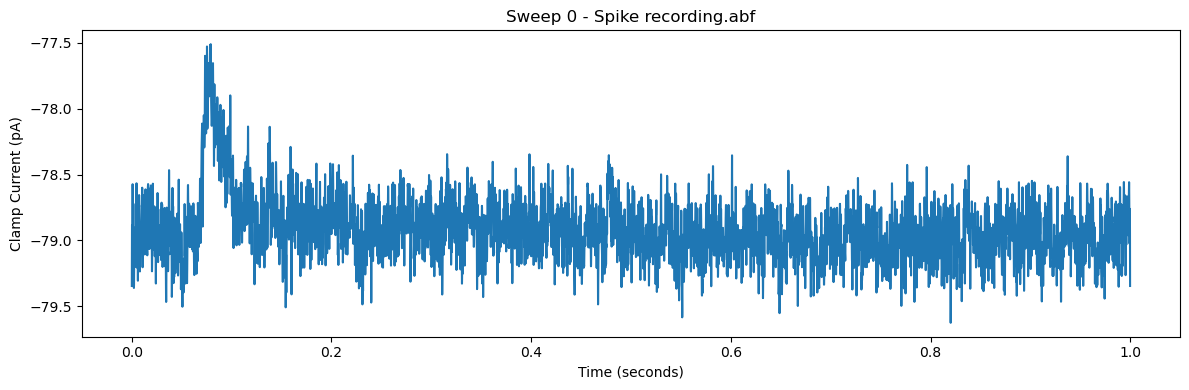

In [5]:
# Select a specific sweep to analyze
if len(abf_files) > 0:
    sweep_to_plot = 0  # Change this to select different sweeps
    
    abf.setSweep(sweep_to_plot)
    time = abf.sweepX
    y_variable = abf.sweepY
    fs = abf.dataRate
    
    # Optional: Apply lowpass Bessel filter
    apply_filter = True  # Set to False to disable filtering
    
    if apply_filter:
        b_lowpass, a_lowpass = signal.bessel(
            4,        # Order of the filter
            2000,     # Cutoff frequency (adjust as needed)
            'low',    # Type of filter
            analog=False,
            norm='phase',
            fs=fs
        )
        signal_filtered = signal.filtfilt(b_lowpass, a_lowpass, y_variable)
    else:
        signal_filtered = y_variable
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(time, signal_filtered)
    ax.set_xlabel(abf.sweepLabelX)
    ax.set_ylabel(abf.sweepLabelY)
    ax.set_title(f'Sweep {sweep_to_plot} - {os.path.basename(selected_file)}')
    
    plt.tight_layout()
    plt.show()


## 5. Spike/Peak Detection


Detected 0 peaks


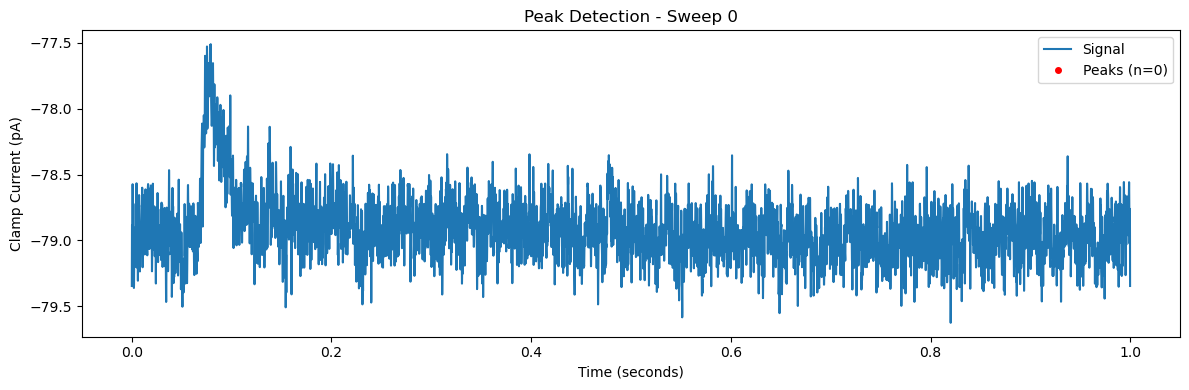

In [6]:
# Peak detection parameters
if len(abf_files) > 0:
    # Threshold for peak detection (adjust based on your data)
    peaks_threshold = 20  # Adjust this value
    detect_negative_peaks = False  # Set to True for negative peaks
    
    # Prepare signal for peak detection
    if detect_negative_peaks:
        signal_for_peaks = -signal_filtered
    else:
        signal_for_peaks = signal_filtered
    
    # Find peaks
    peaks, peaks_dict = find_peaks(signal_for_peaks, height=peaks_threshold)
    
    print(f"Detected {len(peaks)} peaks")
    
    # Plot with detected peaks
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(time, signal_filtered, label='Signal')
    ax.plot(time[peaks], signal_filtered[peaks], "r.", markersize=8, label=f'Peaks (n={len(peaks)})')
    
    ax.set_xlabel(abf.sweepLabelX)
    ax.set_ylabel(abf.sweepLabelY)
    ax.set_title(f'Peak Detection - Sweep {sweep_to_plot}')
    ax.legend()
    
    plt.tight_layout()
    plt.show()


## 6. Analyze all ABF files in the folder



Analyzing: Spike recording.abf
Sweeps: 50, Duration: 1.0s, SR: 10000Hz


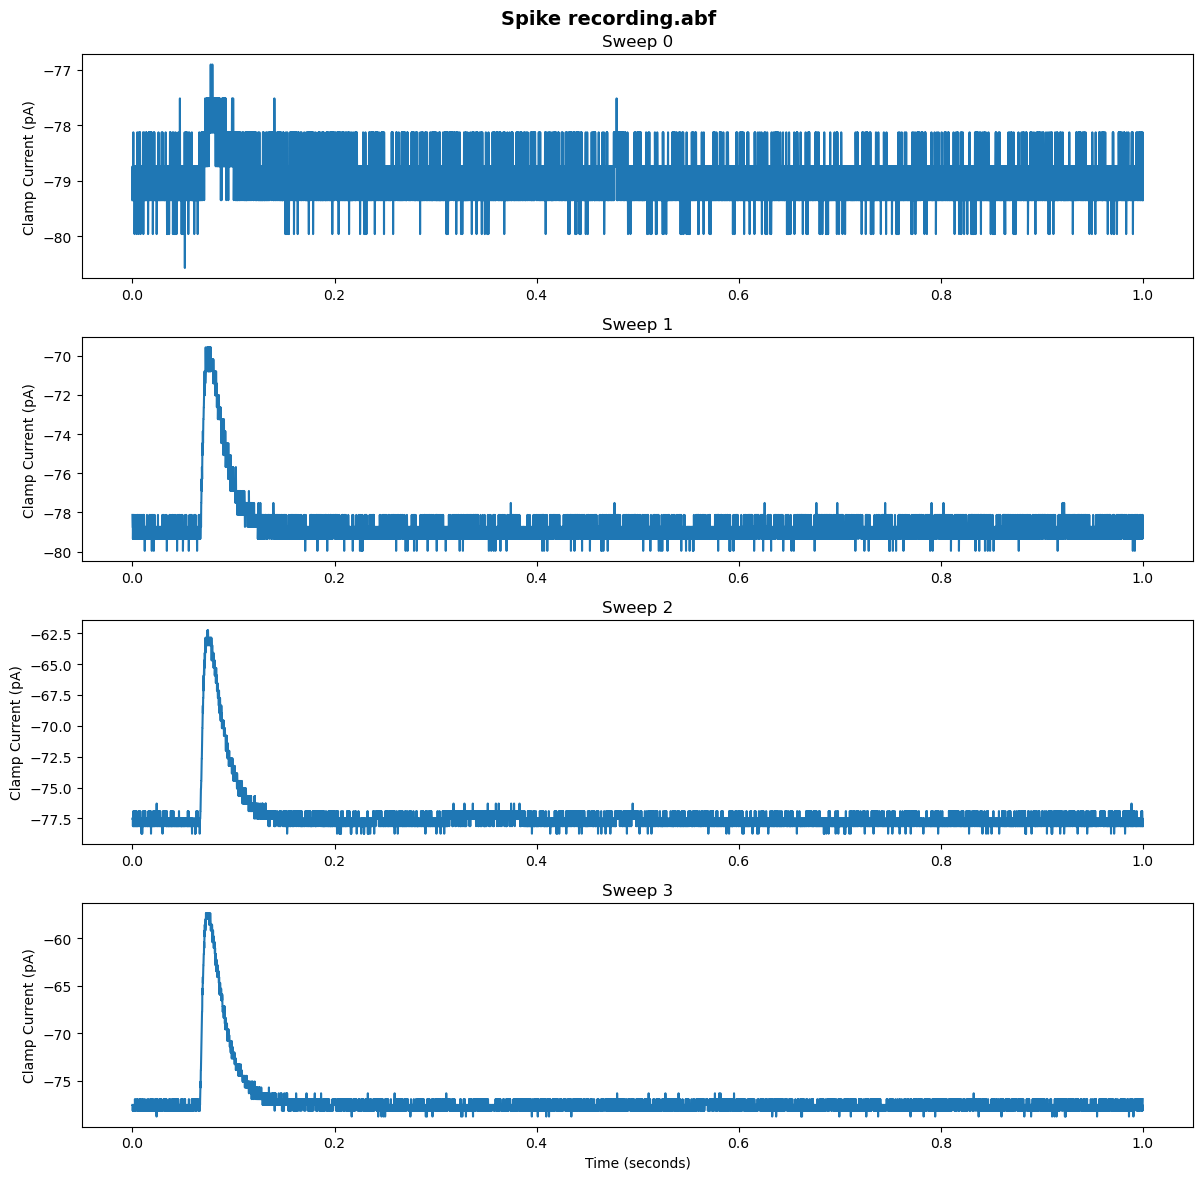


Analyzing: CheRiff current.abf
Sweeps: 50, Duration: 1.0s, SR: 20000Hz


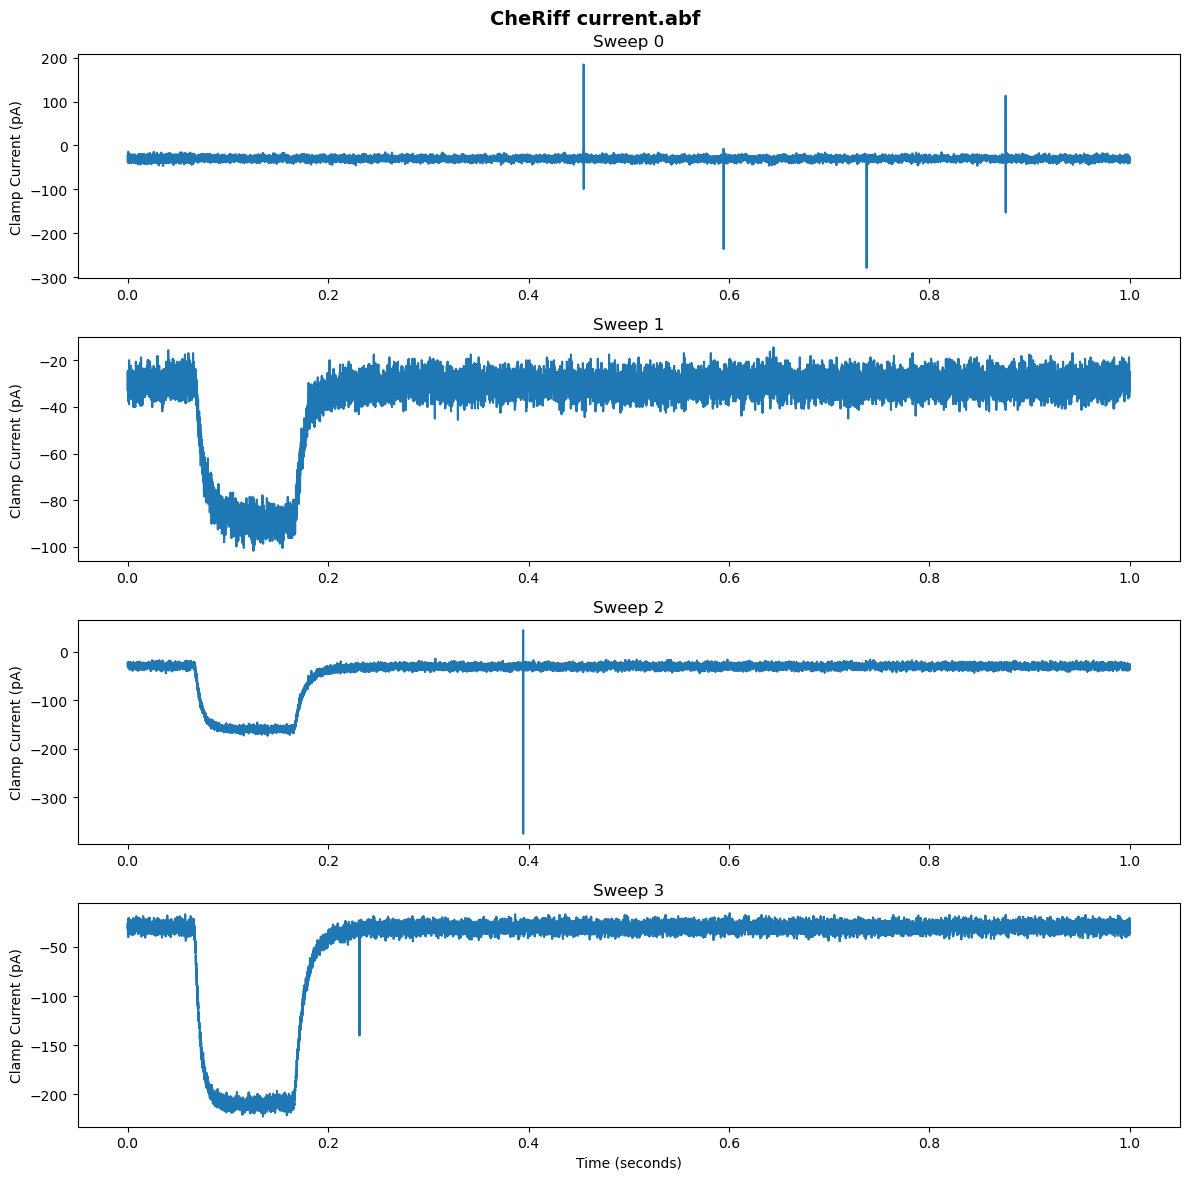

In [7]:
# Loop through all ABF files and create summary plots
if len(abf_files) > 0:
    for abf_file in abf_files:
        print(f"\n{'='*50}")
        print(f"Analyzing: {os.path.basename(abf_file)}")
        print('='*50)
        
        abf = pyabf.ABF(abf_file)
        
        # Print file info
        print(f"Sweeps: {abf.sweepCount}, Duration: {abf.sweepLengthSec}s, SR: {abf.dataRate}Hz")
        
        # Create figure with subplots
        n_sweeps = min(abf.sweepCount, 4)  # Plot maximum 4 sweeps
        fig, axes = plt.subplots(n_sweeps, 1, figsize=(12, 3*n_sweeps))
        
        if n_sweeps == 1:
            axes = [axes]
        
        for i, sweepNumber in enumerate(abf.sweepList[:n_sweeps]):
            abf.setSweep(sweepNumber)
            axes[i].plot(abf.sweepX, abf.sweepY)
            axes[i].set_ylabel(abf.sweepLabelY)
            axes[i].set_title(f'Sweep {sweepNumber}')
            
            if i == n_sweeps - 1:
                axes[i].set_xlabel(abf.sweepLabelX)
        
        fig.suptitle(os.path.basename(abf_file), fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()


## 7. Export summary statistics (optional)


In [8]:
# Create a summary dataframe for all files
if len(abf_files) > 0:
    summary_data = []
    
    for abf_file in abf_files:
        abf = pyabf.ABF(abf_file)
        
        for sweepNumber in abf.sweepList:
            abf.setSweep(sweepNumber)
            
            summary_data.append({
                'Filename': os.path.basename(abf_file),
                'Sweep': sweepNumber,
                'Duration_s': abf.sweepLengthSec,
                'Sampling_Rate_Hz': abf.dataRate,
                'Mean': np.mean(abf.sweepY),
                'Std': np.std(abf.sweepY),
                'Min': np.min(abf.sweepY),
                'Max': np.max(abf.sweepY),
                'Units': abf.sweepUnitsY
            })
    
    summary_df = pd.DataFrame(summary_data)
    print("\nSummary Statistics:")
    print(summary_df.to_string(index=False))
    
    # Optionally save to CSV
    # summary_df.to_csv('analysis_summary.csv', index=False)
    # print("\nSummary saved to 'analysis_summary.csv'")



Summary Statistics:
           Filename  Sweep  Duration_s  Sampling_Rate_Hz       Mean        Std         Min        Max Units
Spike recording.abf      0         1.0             10000 -78.915840   0.415246  -80.566406 -76.904297    pA
Spike recording.abf      1         1.0             10000 -78.626038   1.179641  -79.956055 -69.580078    pA
Spike recording.abf      2         1.0             10000 -77.271240   1.885597  -78.735352 -62.255859    pA
Spike recording.abf      3         1.0             10000 -77.070679   2.517794  -78.735352 -57.373047    pA
Spike recording.abf      4         1.0             10000 -77.990715   2.998609  -79.956055 -54.321289    pA
Spike recording.abf      5         1.0             10000 -78.433289   3.404448  -80.566406 -51.269531    pA
Spike recording.abf      6         1.0             10000 -77.810303   3.828922  -79.956055 -48.217773    pA
Spike recording.abf      7         1.0             10000 -77.813240   4.559162  -79.956055 -44.555664    pA
Spike r

In [9]:
# Your additional analysis code here
